In [16]:
# system
import os
from datetime import datetime
from datetime import timedelta

# data processing and plotting
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yahooFinance

# ml/dl
from pmdarima import auto_arima, AutoARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Download data

In [17]:
def tm_btcusd_download_or_update(filename: str, instrument: str = 'BTC-USD', period: str = 'max', interval: str = '1d', saveToFile: bool = True, override: bool = False):
    """Updates BTCUSD price data up until today's datetime. Saves to csv.

    Args:
        filename (str): CSV filename
        instrument (str): what data to download. Defaults to BTC-USD.
        period (str): 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y and ytd, max. Defaults to max.
        interval (str): 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo. Defaults to 1d.
        saveToFile (bool): save the updated dataset to file. Defaults to True.
        override (bool): overrides file content with downloaded data. Defaults to True.
        
    Returns:
        pd.DataFrame: updated dataframe
    """
    # connect to yahoo and download data
    BTCUSDInfo = yahooFinance.Ticker(instrument)
    BTCUSDData = pd.DataFrame(BTCUSDInfo.history(period=period, interval=interval))
    
    """
        transform data
    """
    def tm_transform_data(df: pd.DataFrame) -> pd.DataFrame:
        # rename columns
        df.columns = list(map(lambda x: x.lower(), df.columns))
        
        # convert date
        if 'date' in df.columns:
            # use data as index
            df.set_index('date', inplace=True)
            
        # convert
        df.index = pd.to_datetime(df.index)
        df.index.name = 'date'
        
        # remove tzinfo (time zone)
        df.index = list(map(lambda x: x.replace(tzinfo=None), pd.to_datetime(df.index)))
        
        return df
    
    # transform downloaded data
    BTCUSDData = tm_transform_data(BTCUSDData)
    
    # override data if needed and return
    if override:
        if saveToFile: BTCUSDData.to_csv(filename)
        return BTCUSDData
    
    # read old dataset and update data
    df_new = None
    if os.path.exists(filename):
        # read into memory
        df = pd.read_csv(filename)
        
        # transform old data
        df = tm_transform_data(df)
        
        # update data up to today's datetime
        timediff = (BTCUSDData.index[-1] - df.index[-1])
        if timediff.total_seconds() > 0:
            df_new = pd.concat(df, BTCUSDData.iloc[df.shape[0]:])
        else:
            df_new = df
    else:
        df_new = BTCUSDData
    
    # save to file if needed
    if saveToFile:
        df_new.to_csv(filename)
        
    return df_new
    

In [18]:
# download latest data and override
df = tm_btcusd_download_or_update('../data/btcusd.csv', override=True)

In [19]:
df = pd.read_csv('../data/btcusd.csv', index_col=[0])
df.index = pd.to_datetime(df.index)
df.tail()

,open,high,low,close,volume,dividends,stock splits
2024-02-13,49941.359375,50358.390625,48406.496094,49742.441406,35593051468,0.0,0.0
2024-02-14,49733.445312,52021.371094,49296.832031,51826.695312,39105608050,0.0,0.0
2024-02-15,51836.785156,52820.066406,51371.628906,51938.554688,38564360533,0.0,0.0
2024-02-16,51937.726562,52537.968750,51641.367188,52160.203125,28180567298,0.0,0.0
2024-02-17,52161.675781,52180.582031,51558.039062,51720.191406,22341152768,0.0,0.0


## EDA

In [20]:
# lets take data for the past 4 years
df = df[datetime(2020, 1, 1):]
df.head()

,open,high,low,close,volume,dividends,stock splits
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,18565664997,0.0,0.0
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,20802083465,0.0,0.0
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,28111481032,0.0,0.0
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,18444271275,0.0,0.0
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,19725074095,0.0,0.0


In [21]:
df.describe()

,open,high,low,close,volume,dividends,stock splits
count,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03,1509.0,1509.0
mean,29355.209392,30019.104947,28648.499191,29381.856003,3.191706e+10,0.0,0.0
std,15132.382105,15525.078540,14679.673361,15128.134313,1.853984e+10,0.0,0.0
min,5002.578125,5331.833984,4106.980957,4970.788086,5.331173e+09,0.0,0.0
25%,17153.914062,17484.720703,16922.431641,17168.566406,1.979304e+10,0.0,0.0
50%,27920.513672,28388.437500,27301.654297,27935.089844,2.888125e+10,0.0,0.0
75%,41348.203125,42235.546875,40234.578125,41374.378906,3.913940e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0


In [22]:
# drop last 2 columns
df = df.drop(['dividends', 'stock splits'], axis=1)
df.head()

,open,high,low,close,volume
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,19725074095


In [23]:
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [24]:
def tm_plot_price_data(df_price: pd.DataFrame, title: str = None, detailed: bool = False, figsize: tuple[int, int] = (7, 3)):
    # define figure
    plt.figure(figsize=figsize)
    plt.plot(df_price)

    # plot data
    plt.grid(c = 'gray', ls = '--', lw=0.4)
    if detailed:
        statdata = {
            'mean': (df_price.mean(), 'r'), 
            'median': (df_price.median(), 'g'),
        }
        
        # plot statdata
        for key, value in statdata.items():
            plt.text(x=df_price.index[0], y=value[0], s=key)
            plt.axhline(y=value[0], c=value[1], lw='0.7')
    
    # add info
    if title: plt.title(title)
    plt.ylabel('price')
    plt.xlabel('time')
    
    # plot
    plt.show()

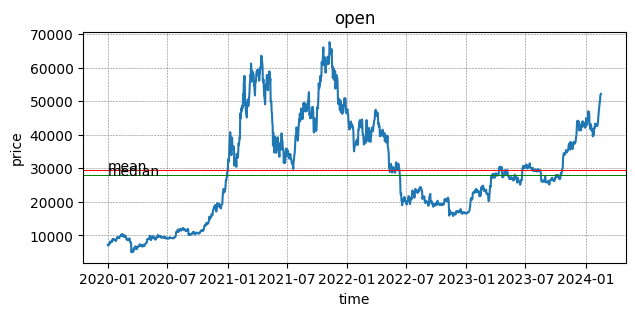

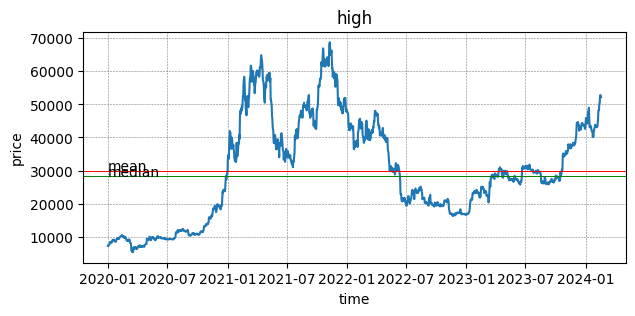

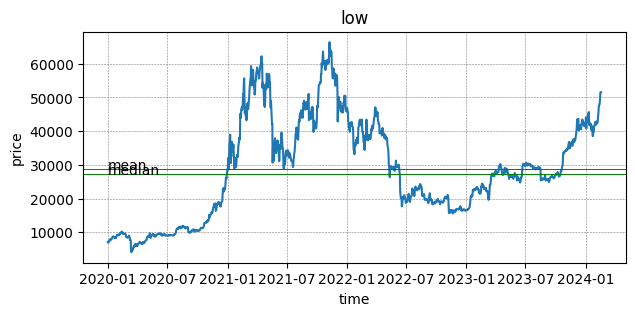

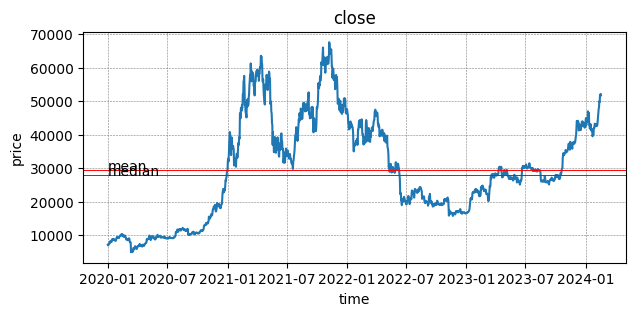

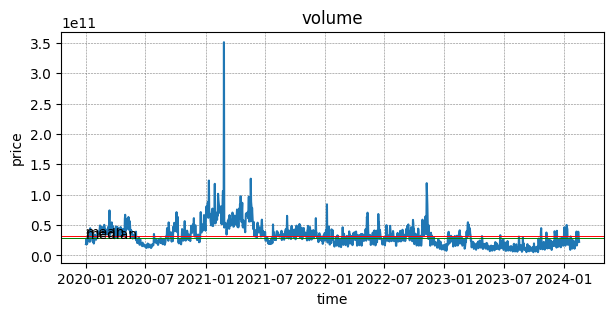

In [25]:
for colname in df.columns:
    tm_plot_price_data(df[colname], title=colname, detailed=True)

## Preprocessing

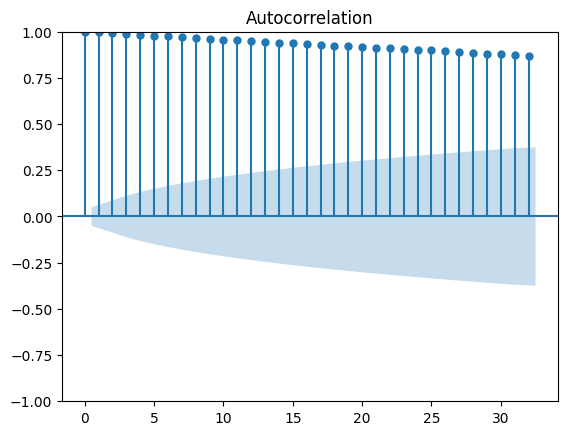

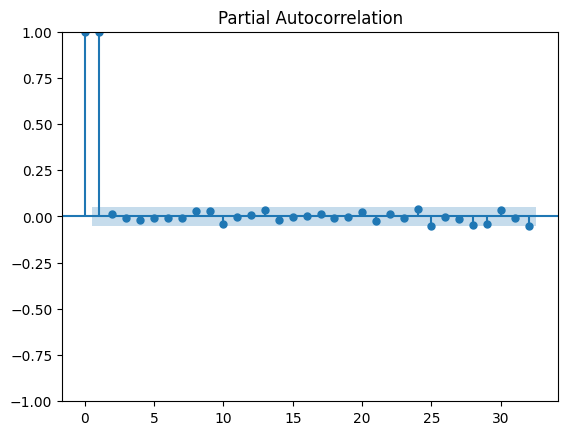

In [53]:
plot_acf(df.close)
plot_pacf(df.close)
plt.show()

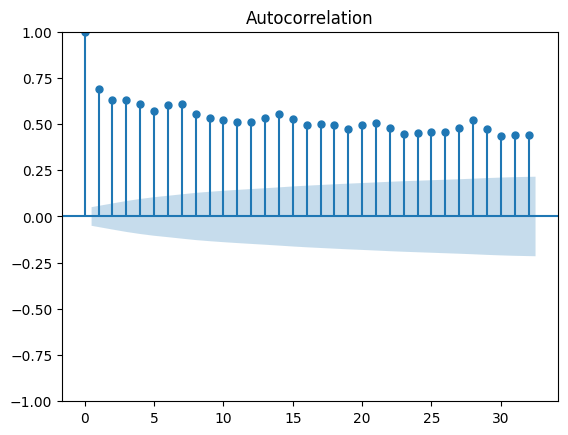

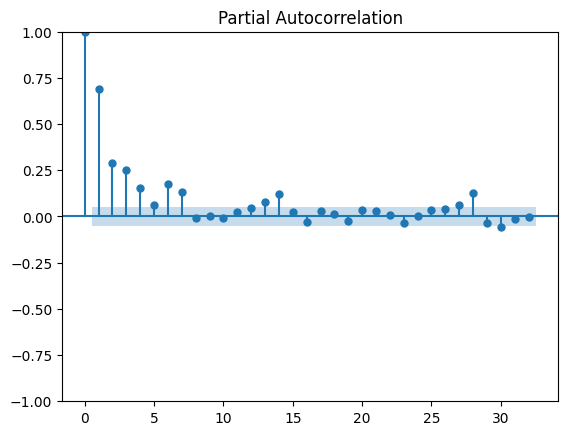

In [27]:
plot_acf(df.volume)
plot_pacf(df.volume)
plt.show()

In [28]:
# lets take the first difference and see what happens
# (out of curiosity)
df_1diff = df.diff()[1:]
df_1diff.head()

,open,high,low,close,volume
2020-01-02,7.659180,-42.175293,-239.674316,-214.704102,2.236418e+09
2020-01-03,-218.122559,201.560059,-20.273926,359.414062,7.309398e+09
2020-01-04,360.946777,13.670410,394.518066,65.772461,-9.667210e+09
2020-01-05,65.076172,117.111328,91.021484,0.660645,1.280803e+09
2020-01-06,0.000488,237.370117,8.757324,357.901855,3.551188e+09


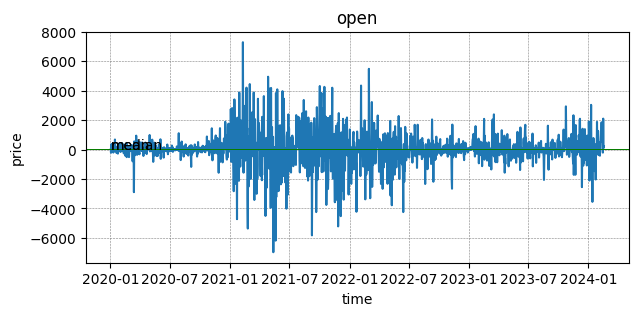

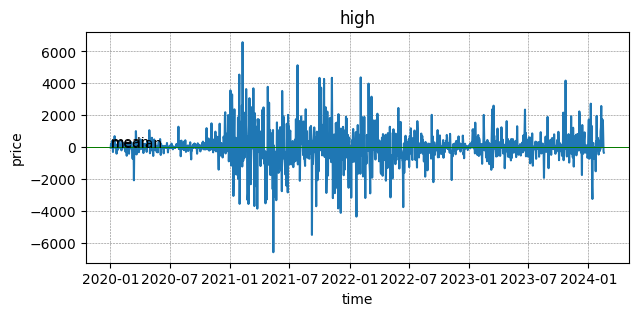

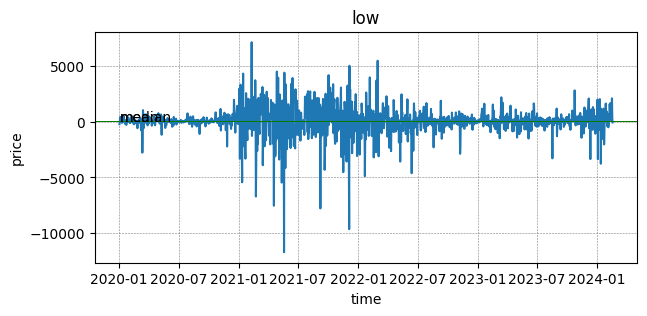

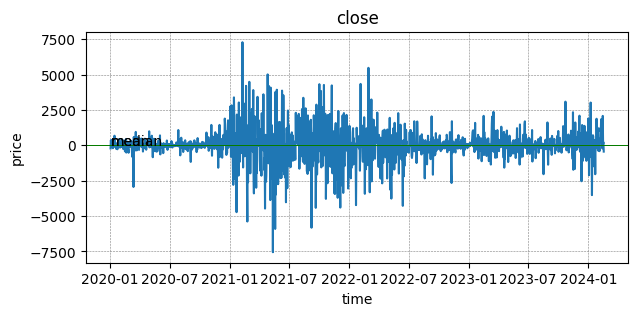

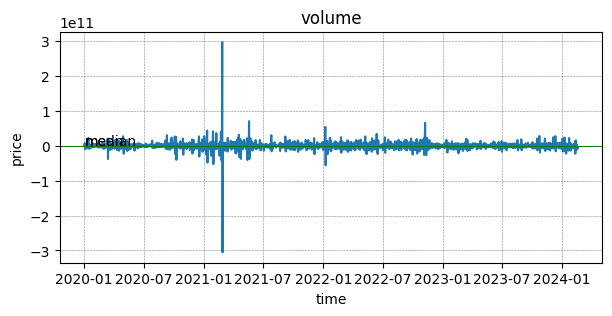

In [37]:
for colname in df_1diff.columns:
    tm_plot_price_data(df_1diff[colname], title=colname, detailed=True)

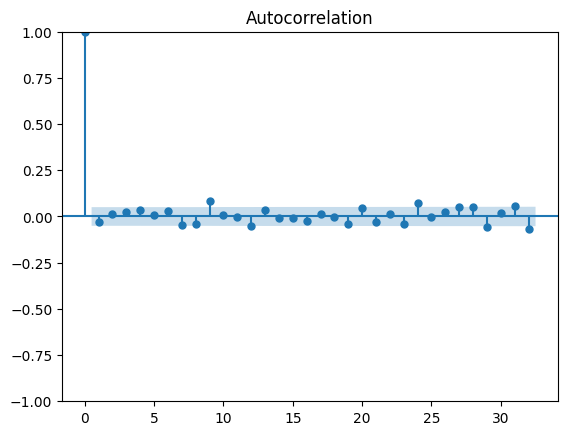

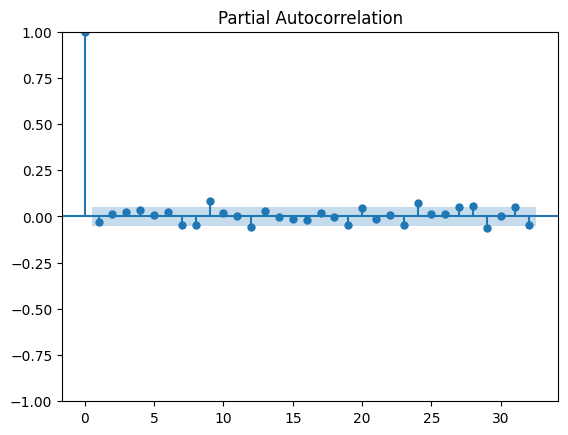

In [29]:
plot_acf(df_1diff.close)
plot_pacf(df_1diff.close)
plt.show()

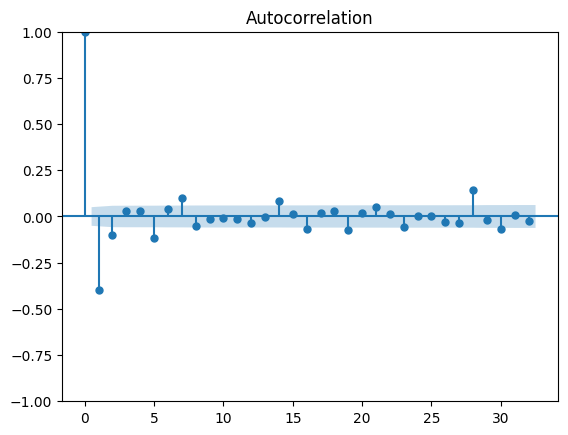

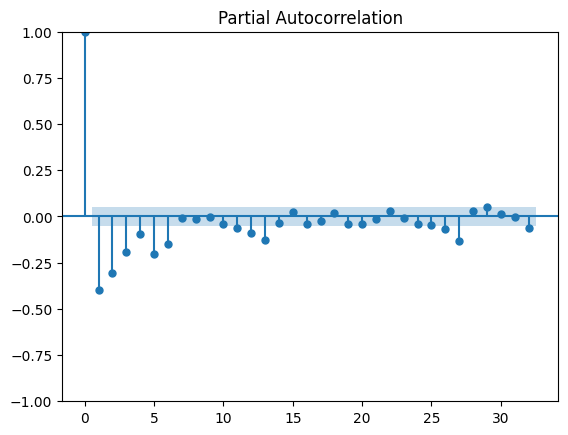

In [30]:
plot_acf(df_1diff.volume)
plot_pacf(df_1diff.volume)
plt.show()

## Training

In [31]:
# split into train and test data
start_date, end_date = df.index[0], df.index[-1] - timedelta(days=7)
df_train = df[:end_date-timedelta(days=1)]
df_test = df[end_date:]

In [32]:
df_train.head()

,open,high,low,close,volume
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,19725074095


In [33]:
df_test.head()

,open,high,low,close,volume
2024-02-10,47153.527344,48146.171875,46905.320312,47771.277344,16398681570
2024-02-11,47768.968750,48535.937500,47617.406250,48293.917969,19315867136
2024-02-12,48296.386719,50280.476562,47745.761719,49958.222656,34511985805
2024-02-13,49941.359375,50358.390625,48406.496094,49742.441406,35593051468
2024-02-14,49733.445312,52021.371094,49296.832031,51826.695312,39105608050


In [34]:
df.shape, df_train.shape, df_test.shape

((1509, 5), (1501, 5), (8, 5))

### AUTO ARIMA

In [35]:
model = AutoARIMA(
    # seasonal=False, 
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
).fit(y=df_train.close, x=df_train.close)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25392.299, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25395.271, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25395.649, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25395.698, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25394.080, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=25398.881, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25399.054, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=25401.931, Time=0.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=25394.225, Time=1.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25397.585, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=25399.839, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=25400.000, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=25396.567, Time=1.53 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=25391.120, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0

In [38]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1501
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -12690.560
Date:                Sat, 17 Feb 2024   AIC                          25391.120
Time:                        18:01:16   BIC                          25417.686
Sample:                    01-01-2020   HQIC                         25401.017
                         - 02-09-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8200      0.022     37.930      0.000       0.778       0.862
ar.L2         -0.9464      0.021    -45.719      0.000      -0.987      -0.906
ma.L1         -0.8475      0.021    -41.312      0.0

In [54]:
custom_model = ARIMA(endog=df['close'], order=(5, 1, 2)).fit()

c:\Users\kiril\.pyenv\pyenv-win\versions\3.9.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kiril\.pyenv\pyenv-win\versions\3.9.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kiril\.pyenv\pyenv-win\versions\3.9.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [55]:
print(custom_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1509
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -12760.645
Date:                Sat, 17 Feb 2024   AIC                          25537.290
Time:                        18:30:34   BIC                          25579.839
Sample:                    01-01-2020   HQIC                         25553.137
                         - 02-17-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0016      0.603      0.003      0.998      -1.181       1.184
ar.L2          0.9097      0.573      1.587      0.112      -0.214       2.033
ar.L3          0.0530      0.041      1.298      0.1

In [129]:
predictions = model.predict(n_periods=df_test.shape[0])
residuals = df_test.close - predictions

In [130]:
df_test.close

2024-01-23    39845.550781
2024-01-24    40077.074219
2024-01-25    39933.808594
2024-01-26    41816.871094
2024-01-27    42120.054688
2024-01-28    42035.593750
2024-01-29    43288.246094
2024-01-30    43404.000000
Name: close, dtype: float64

In [131]:
predictions

2024-01-23    39532.668728
2024-01-24    39614.419850
2024-01-25    39657.373968
2024-01-26    39615.188068
2024-01-27    39540.040977
2024-01-28    39518.461470
2024-01-29    39571.888821
2024-01-30    39636.014749
Freq: D, dtype: float64

In [356]:
def tm_plot_pred_vs_data(predictions: pd.DataFrame, true_data: pd.DataFrame, df_logs: pd.DataFrame = None, figsize: tuple[int, int] = (7, 3)):
    residuals = true_data - predictions
    
    # plot residuals
    plt.figure(figsize=figsize)
    plt.plot(residuals)
    plt.title('Residuals from AR Model')
    plt.ylabel('Error')
    plt.axhline(0, color='r', linestyle='--', alpha=0.2)
    plt.xticks(size=figsize[0])
    plt.show()

    # plot predictions vs true data
    plt.figure(figsize=figsize)
    plt.plot(true_data)
    plt.plot(predictions)
    if df_logs is not None:
        for i, idx in enumerate(df_logs.index):
            if df_logs.action[i].value == -1:
                plt.axvline(x=idx.to_pydatetime(), color='r')
            elif df_logs.action[i].value == 1:
                plt.axvline(x=idx.to_pydatetime(), color='b')
            else:
                plt.axvline(x=idx.to_pydatetime(), color='gray')
    plt.legend(('Data', 'Predictions'))
    plt.title('Predicted vs true data')
    plt.ylabel('data')
    plt.xticks(size=figsize[0])
    plt.show()

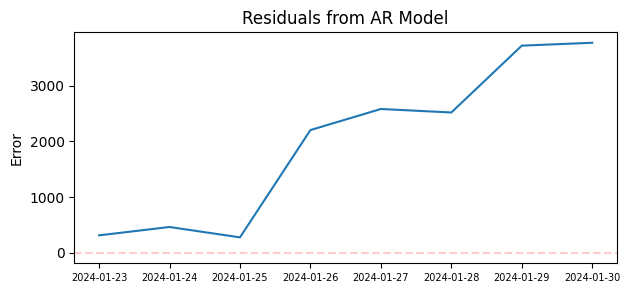

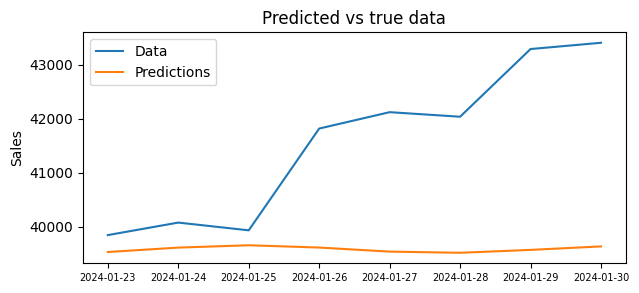

In [201]:
tm_plot_pred_vs_data(predictions, df_test.close)

In [134]:
mae = mean_absolute_error(df_test.close, predictions)
rmse = np.sqrt(mean_squared_error(df_test.close, predictions))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 1979.39
Root Mean Squared Error: 2404.09


## Simulation

### Utils

In [135]:
# appends row to time series dataframe (assumes date is used as index)
def df_append_row(df: pd.DataFrame, value: pd.Series):
    return pd.concat([
        df, 
        pd.DataFrame({df.index.name: value.index, df.columns[0]: value[0]}, index=[0]).set_index(df.index.name)
    ])


# runs the training process (unsupervised, without correcting for true value, using its predicted value for training)
def run_training_unsupervised(df_train: pd.DataFrame) -> pd.DataFrame:
    # train the model
    model = AutoARIMA(
        trace=False, 
        error_action='ignore', 
        suppress_warnings=True
    ).fit(y=df_train, x=df_train)
    
    # predict
    y_pred = model.predict(n_periods=1)
    
    # add it to the training dataset
    df_train = df_append_row(df_train, y_pred)
    
    return df_train


# runs the training process (supervised, correcting for true value and using its true value for training)
def run_training_supervised(df_train: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    # train the model
    model = AutoARIMA(
        trace=False, 
        error_action='ignore', 
        suppress_warnings=True
    ).fit(y=df_train, x=df_train)
    
    # predict
    y_pred = model.predict(n_periods=1)
    
    return df_train, y_pred

---

In [156]:
"""
    This simulation is using its own predicted data
    to predict the future value for N periods.
    
    The predicted value isn't adjusted; the model is trained 
    using the previous values predicted by the model. 
"""
df_sim_train = df_train.close.reset_index().set_index('index')
df_sim_test = df_test.close.reset_index().set_index('index')
for i in range(df_sim_test.shape[0]):
    print(f'iteration {i:2d} | {df_sim_test.index[i]} | error ', end='')
    df_sim_train = run_training_unsupervised(df_sim_train)
    print(f'{((df_sim_test.iloc[i].values - df_sim_train.iloc[-1].values)/df_sim_test.iloc[i].values)[0]:2.2f}')
    

iteration  0 | 2024-01-23 00:00:00 | error 0.01
iteration  1 | 2024-01-24 00:00:00 | error 0.01
iteration  2 | 2024-01-25 00:00:00 | error 0.01
iteration  3 | 2024-01-26 00:00:00 | error 0.05
iteration  4 | 2024-01-27 00:00:00 | error 0.06
iteration  5 | 2024-01-28 00:00:00 | error 0.06
iteration  6 | 2024-01-29 00:00:00 | error 0.09
iteration  7 | 2024-01-30 00:00:00 | error 0.09


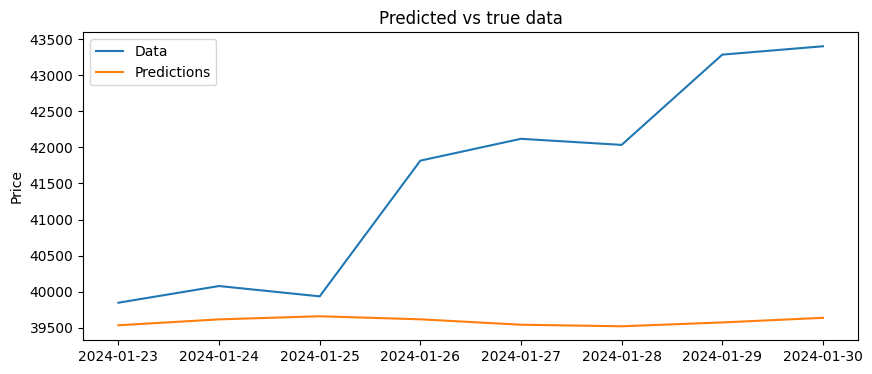

In [157]:
# get predicted
predicted = df_sim_train.loc[df_sim_test.index[0]:]

plt.figure(figsize=(10,4))
plt.plot(df_sim_test)
plt.plot(predicted)
plt.legend(('Data', 'Predictions'))
plt.title('Predicted vs true data')
plt.ylabel('Price')
plt.show()

In [158]:
mae = mean_absolute_error(df_sim_test, predicted)
rmse = np.sqrt(mean_squared_error(df_sim_test, predicted))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 1979.33
Root Mean Squared Error: 2404.04


---

In [160]:
"""
    This simulation is using the true values
    to predict the future value for N periods.
    
    It predicts for the next period, then recives 
    the true value, and predicts for next period using
    the true value, etc... 
"""
df_predictions = pd.DataFrame(columns=['index', 'price']).set_index('index')
df_sim_train = df_train.close.reset_index().set_index('index')
df_sim_test = df_test.close.reset_index().set_index('index')
for i in range(df_sim_test.shape[0]):
    print(f'iteration {i:2d} | {df_sim_test.index[i]} | error ', end='')
    
    # train the model and predict value for the next period
    df_sim_train, y_pred = run_training_supervised(df_sim_train)

    # append to predictions
    df_predictions = df_append_row(df_predictions, y_pred)
    
    # add true value to train for the next training iteration
    df_sim_train = pd.concat([df_sim_train, df_sim_test.iloc[[i]]])
    
    print(f'{((df_sim_test.iloc[i].values - df_predictions.iloc[-1].values)/df_sim_test.iloc[i].values)[0]:2.2f}')
    

iteration  0 | 2024-01-23 00:00:00 | error 0.01
iteration  1 | 2024-01-24 00:00:00 | error 0.00
iteration  2 | 2024-01-25 00:00:00 | error -0.00
iteration  3 | 2024-01-26 00:00:00 | error 0.05
iteration  4 | 2024-01-27 00:00:00 | error 0.01
iteration  5 | 2024-01-28 00:00:00 | error -0.00
iteration  6 | 2024-01-29 00:00:00 | error 0.03
iteration  7 | 2024-01-30 00:00:00 | error 0.00


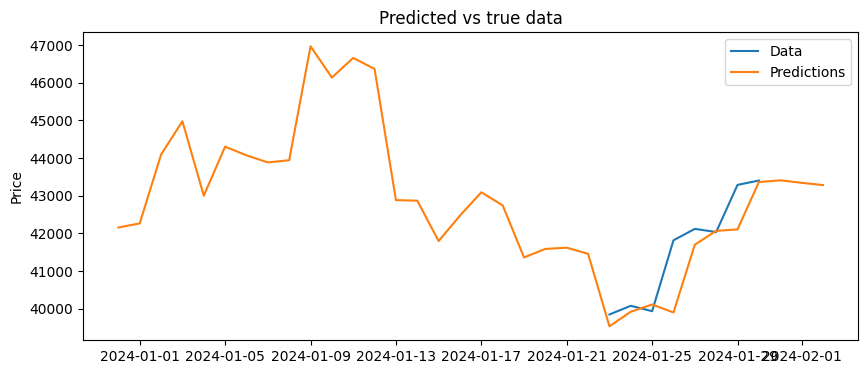

In [358]:
# get predicted
predicted = df_predictions

plt.figure(figsize=(10,4)) 
plt.plot(df_sim_test)
plt.plot(predicted)
plt.legend(('Data', 'Predictions'))
plt.title('Predicted vs true data')
plt.ylabel('Price')
plt.show()

In [162]:
mae = mean_absolute_error(df_sim_test, predicted)
rmse = np.sqrt(mean_squared_error(df_sim_test, predicted))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 529.73
Root Mean Squared Error: 821.92


### Simulate strategies

In [440]:
import random
from enum import Enum


class Strategies(Enum):
    """Trading Strategies."""
    NONE = 'none'
    RANDOM_CHOICE = "randomly select action, to buy/sell"
    AS_PREDICTED = "buy or sell as the model predicts"
    

class TradeAction(Enum):
    """Trading action."""
    NONE = 0
    BUY = 1
    SELL = -1
    

def run_simulation(
    df_sim_train: pd.DataFrame, 
    df_sim_true: pd.DataFrame, 
    n_periods: int = 7, 
    balance: float = 500, 
    lots: float = 0.01, 
    strategy: Strategies = Strategies.NONE,
    verbose: bool = True,
) -> tuple[pd.DataFrame, pd.DataFrame, float]:
    """Run ARIMA model simulation

    Args:
        df_sim_train (pd.DataFrame): training data
        df_sim_true (pd.DataFrame): true data
        n_periods (int, optional): Predict N periods after true data is exausted (nothing is traded during this period). Defaults to 7.
        balance (float, optional): Initial balance. Defaults to 500.
        lots (float, optional): Action lots per deal. Defaults to 0.01.
        strategy (Strategies, optional): Trading strategy to use. Defaults to Strategies.NONE.
        verbose (bool, optional): Verbose output. Defaults to True.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame, float]: (predictions, TradeAction logs, balance)
    """
    # predicted list
    df_predictions = pd.DataFrame(columns=[df_sim_train.index.name, df_sim_train.columns[0]]).set_index(df_sim_train.index.name)
    
    # trade action
    df_trade_action_logs = pd.DataFrame(columns=[df_sim_train.index.name, 'action']).set_index(df_sim_train.index.name)
    
    # save initial balance value
    initial_balance = balance
    
    # track our trading action
    trade_action = TradeAction.NONE
    
    if verbose: print(f'Running simulation. Strategy chosen: {strategy}')
    
    # iterations
    for i in range(df_sim_true.shape[0]+n_periods):
        if verbose: print(f'iteration {i:2d} | {df_sim_true.index[0]+timedelta(days=i)} | ', end='')
        
        # train the model and predict value for the next period
        df_sim_train, y_pred = run_training_supervised(df_sim_train)

        # append to predictions
        df_predictions = df_append_row(df_predictions, y_pred)
        
        # update balance before next iteration
        initial_balance = balance
                
        if i < df_sim_true.shape[0]:
            # add true value to train for the next training iteration
            df_sim_train = pd.concat([df_sim_train, df_sim_true.iloc[[i]]])
            
            # trade based on selected strategy
            if strategy == Strategies.RANDOM_CHOICE:
                """
                    If action is none, initiate a trade.
                """
                if trade_action == TradeAction.NONE:
                    trade_action = TradeAction(1 if random.getrandbits(1) else -1)
                else:                    
                    # close the deal and adjust balance
                    balance = balance + lots * (df_sim_true.iloc[i].values - df_sim_true.iloc[i-1].values)[0] * trade_action.value
                    
                    # select new trading action
                    trade_action = TradeAction(1 if random.getrandbits(1) else -1)

            elif strategy == Strategies.AS_PREDICTED:
                """
                    Start trading once we have predicted values to work with.
                """
                # close the deal and adjust balance
                balance = balance + lots * (df_sim_train.iloc[-1].values - df_sim_train.iloc[-2].values)[0] * trade_action.value
                
                # # select new trading action: sell IF pred is lower than from previous day ELSE buy
                # trade_action = TradeAction.SELL if (df_predictions.iloc[-1].values - df_sim_true.iloc[i-1].values)[0] < 0 else TradeAction.BUY
                
                # should use this: select new trading action: sell IF pred is lower than from previous day ELSE buy (shifted)
                trade_action = TradeAction.SELL if (df_predictions.iloc[-1].values - df_sim_train.iloc[-2].values)[0] < 0 else TradeAction.BUY                        
            if verbose: 
                print(f'error {((df_sim_true.iloc[i].values - df_predictions.iloc[-1].values)/df_sim_true.iloc[i].values)[0]:.2f}% | ', end='')
        else:
            # use predicted value, add it to train dataset for the next training iteration
            df_sim_train = pd.concat([df_sim_train, df_predictions.iloc[[-1]]])
            
            # reset action
            # trade_action = TradeAction.NONE
            
            # what should the model do
            trade_action = TradeAction.SELL if (df_predictions.iloc[-1].values - df_sim_train.iloc[-2].values)[0] < 0 else TradeAction.BUY
            
            if verbose: 
                print('error - | ', end='')
        
        # update trade action logs
        df_trade_action_logs = pd.concat([df_trade_action_logs, pd.DataFrame({df_sim_train.index.name: [df_predictions.index[-1]], 'action': [trade_action]}).set_index(df_sim_train.index.name)])
        
        if verbose: 
            print(f'balance {balance:.2f} | change {(100*(balance - initial_balance)/initial_balance):.2f}% | on next {trade_action}')
        
    return df_predictions, df_trade_action_logs, balance


def tm_plot_report(df_true: pd.DataFrame, df_predicted: pd.DataFrame, df_logs: pd.DataFrame = None, shifted: bool = False):
    # plot
    predicted = df_predicted.copy()
    # if shifted: predicted.index = predicted.index - timedelta(days=1)
    if shifted: predicted = predicted.shift(-1)
    tm_plot_pred_vs_data(predicted, df_true, df_logs)
    
    # calculate error
    mae = mean_absolute_error(df_true, predicted[(1 if shifted else 0):len(df_true) + (1 if shifted else 0)])
    rmse = np.sqrt(mean_squared_error(df_true, predicted[(1 if shifted else 0):len(df_true) + (1 if shifted else 0)]))
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')

In [450]:
df_sim_true.iloc[0].name 

Timestamp('2024-01-16 00:00:00')

#### No strategy (testing)

In [190]:
# split into train and test data
start_date, end_date = df.index[0], df.index[-1] - timedelta(days=7)
df_train = df[:end_date-timedelta(days=1)]
df_true = df[end_date:]

# transform data
df_sim_train = df_train.close.reset_index().set_index('index')
df_sim_true = df_true.close.reset_index().set_index('index')

In [191]:
# run simulation
df_predictions, df_logs, _ = run_simulation(df_sim_train=df_sim_train, df_sim_true=df_sim_true, n_periods=3)

Running simulation. Strategy chosen: Strategies.NONE
iteration  0 | 2024-01-23 00:00:00 | error 0.01% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  1 | 2024-01-24 00:00:00 | error 0.00% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  2 | 2024-01-25 00:00:00 | error -0.00% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  3 | 2024-01-26 00:00:00 | error 0.05% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  4 | 2024-01-27 00:00:00 | error 0.01% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  5 | 2024-01-28 00:00:00 | error -0.00% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  6 | 2024-01-29 00:00:00 | error 0.03% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  7 | 2024-01-30 00:00:00 | error 0.00% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  8 | 2024-01-31 00:00:00 | error - | balance 500.00 | change 0.00% | on

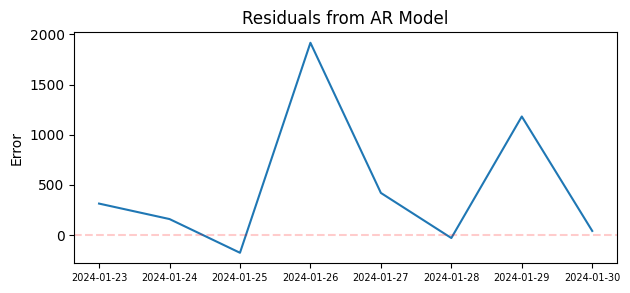

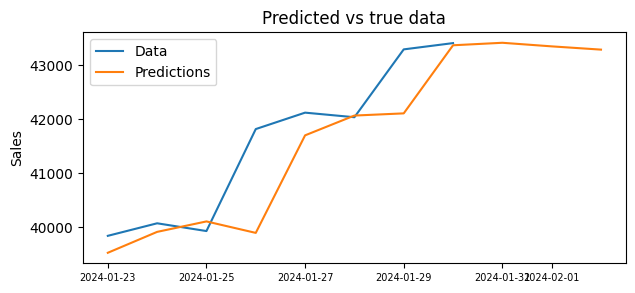

Mean Absolute Error: 529.73
Root Mean Squared Error: 821.92


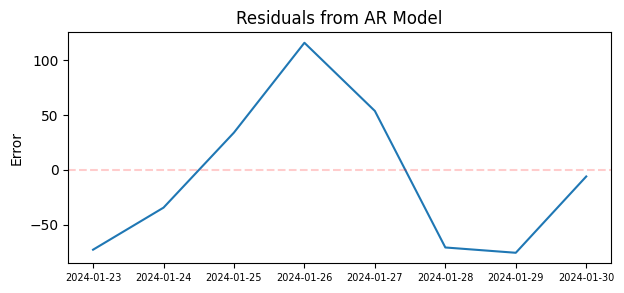

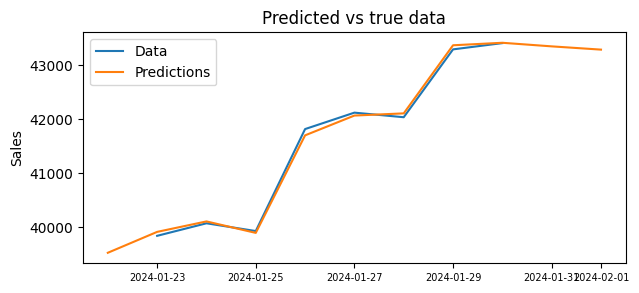

Mean Absolute Error: 58.04
Root Mean Squared Error: 66.02


In [192]:
tm_plot_report(df_sim_true, df_predictions)
tm_plot_report(df_sim_true, df_predictions, shifted=True)

In [196]:
df_logs.head()

,action
index,
2024-01-23,TradeAction.NONE
2024-01-24,TradeAction.NONE
2024-01-25,TradeAction.NONE
2024-01-26,TradeAction.NONE
2024-01-27,TradeAction.NONE


### Random choice

In [360]:
# split into train and test data
start_date, end_date = df.index[0], df.index[-1] - timedelta(days=30)
df_train = df[:end_date-timedelta(days=1)]
df_true = df[end_date:]

# transform data
df_sim_train = df_train.close.reset_index().set_index('index')
df_sim_true = df_true.close.reset_index().set_index('index')

# run simulation
df_predictions, df_logs, _ = run_simulation(
    df_sim_train=df_sim_train, 
    df_sim_true=df_sim_true, 
    n_periods=3,
    balance=500,
    lots=0.01,
    strategy=Strategies.RANDOM_CHOICE,
    verbose=True,
)

Running simulation. Strategy chosen: Strategies.RANDOM_CHOICE
iteration  0 | 2023-12-31 00:00:00 | error 0.00% | balance 500.00 | change 0.00% | on next TradeAction.SELL
iteration  1 | 2024-01-01 00:00:00 | error 0.04% | balance 480.98 | change -3.80% | on next TradeAction.SELL
iteration  2 | 2024-01-02 00:00:00 | error 0.02% | balance 473.07 | change -1.64% | on next TradeAction.SELL
iteration  3 | 2024-01-03 00:00:00 | error -0.05% | balance 494.17 | change 4.46% | on next TradeAction.BUY
iteration  4 | 2024-01-04 00:00:00 | error 0.03% | balance 507.49 | change 2.69% | on next TradeAction.BUY
iteration  5 | 2024-01-05 00:00:00 | error -0.00% | balance 507.32 | change -0.03% | on next TradeAction.BUY
iteration  6 | 2024-01-06 00:00:00 | error -0.00% | balance 505.58 | change -0.34% | on next TradeAction.SELL
iteration  7 | 2024-01-07 00:00:00 | error 0.00% | balance 506.04 | change 0.09% | on next TradeAction.SELL
iteration  8 | 2024-01-08 00:00:00 | error 0.06% | balance 475.77 | ch

In [361]:
df_logs.head()

,action
index,
2023-12-31,TradeAction.SELL
2024-01-01,TradeAction.SELL
2024-01-02,TradeAction.SELL
2024-01-03,TradeAction.BUY
2024-01-04,TradeAction.BUY


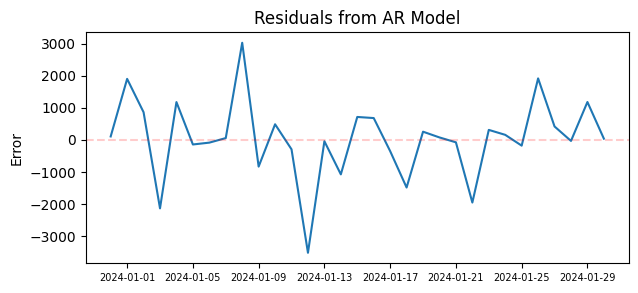

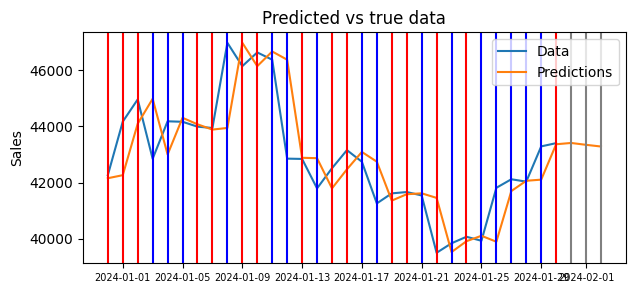

Mean Absolute Error: 824.57
Root Mean Squared Error: 1226.19


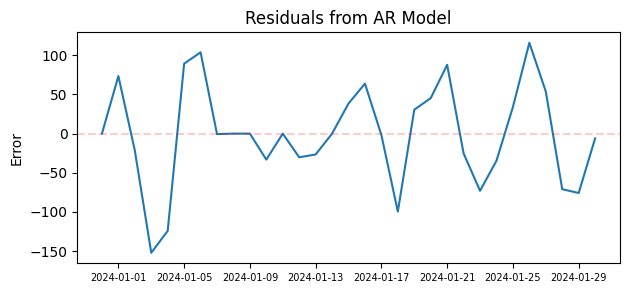

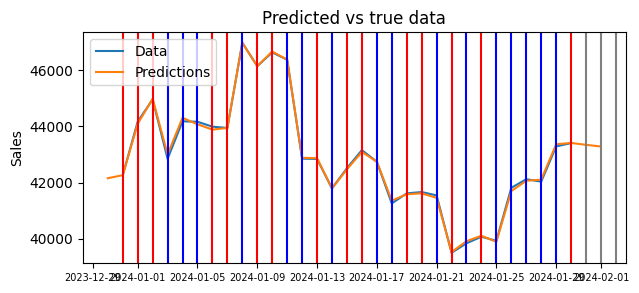

Mean Absolute Error: 48.79
Root Mean Squared Error: 64.17


In [362]:
tm_plot_report(df_sim_true, df_predictions, df_logs=df_logs)
tm_plot_report(df_sim_true, df_predictions, df_logs=df_logs, shifted=True)

### AS_PREDICTED
Buy on bullish and sell on bearish price predictions

In [439]:
# split into train and test data
start_date, end_date = df.index[0], df.index[-1] - timedelta(days=14)
df_train = df[:end_date-timedelta(days=1)]
df_true = df[end_date:]

# transform data
df_sim_train = df_train.close.reset_index().set_index('index')
df_sim_true = df_true.close.reset_index().set_index('index')

# run simulation
df_predictions, df_logs, _ = run_simulation(
    df_sim_train=df_sim_train, 
    df_sim_true=df_sim_true, 
    n_periods=3,
    balance=500,
    lots=0.01,
    strategy=Strategies.AS_PREDICTED,
    verbose=True,
)

Running simulation. Strategy chosen: Strategies.AS_PREDICTED
iteration  0 | 2024-01-16 00:00:00 | error 0.02% | balance 500.00 | change 0.00% | on next TradeAction.SELL
iteration  1 | 2024-01-17 00:00:00 | error -0.01% | balance 504.12 | change 0.82% | on next TradeAction.SELL
iteration  2 | 2024-01-18 00:00:00 | error -0.04% | balance 518.93 | change 2.94% | on next TradeAction.BUY
iteration  3 | 2024-01-19 00:00:00 | error 0.01% | balance 522.49 | change 0.69% | on next TradeAction.BUY
iteration  4 | 2024-01-20 00:00:00 | error 0.00% | balance 522.96 | change 0.09% | on next TradeAction.SELL
iteration  5 | 2024-01-21 00:00:00 | error -0.00% | balance 524.16 | change 0.23% | on next TradeAction.SELL
iteration  6 | 2024-01-22 00:00:00 | error -0.05% | balance 544.55 | change 3.89% | on next TradeAction.SELL
iteration  7 | 2024-01-23 00:00:00 | error 0.01% | balance 541.16 | change -0.62% | on next TradeAction.BUY
iteration  8 | 2024-01-24 00:00:00 | error 0.00% | balance 543.48 | chang

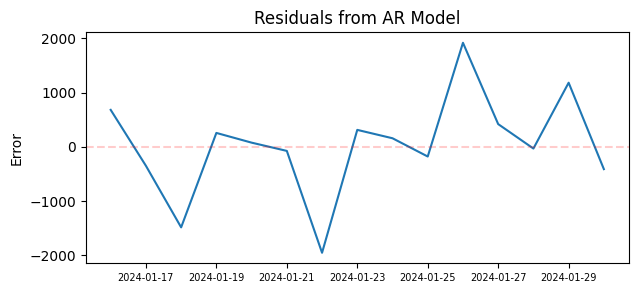

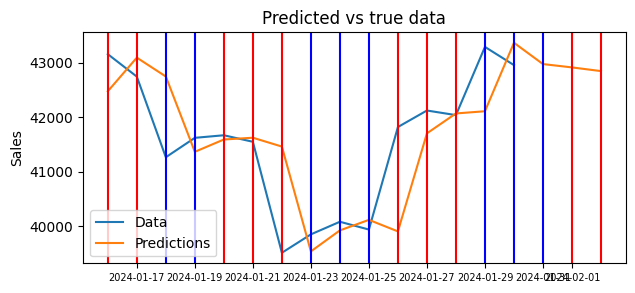

Mean Absolute Error: 632.01
Root Mean Squared Error: 903.22


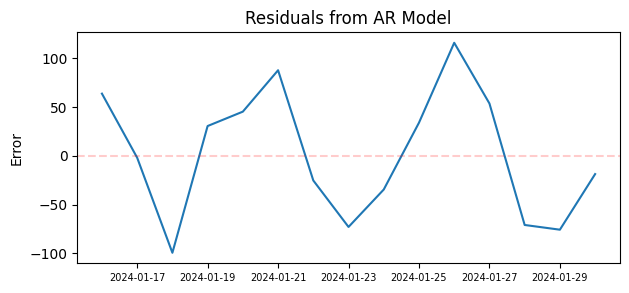

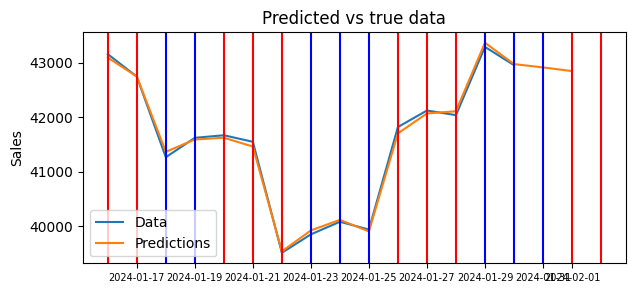

Mean Absolute Error: 594.04
Root Mean Squared Error: 879.39


In [441]:
tm_plot_report(df_sim_true, df_predictions, df_logs)
tm_plot_report(df_sim_true, df_predictions, df_logs, shifted=True)

In [443]:
df_predictions.shift(0).tail()

,close
index,
2024-01-29,42106.581735
2024-01-30,43364.078990
2024-01-31,42972.748143
2024-02-01,42911.680016
2024-02-02,42843.935565


In [444]:
df_sim_true.tail()

,close
index,
2024-01-26,41816.871094
2024-01-27,42120.054688
2024-01-28,42035.593750
2024-01-29,43288.246094
2024-01-30,42954.000000


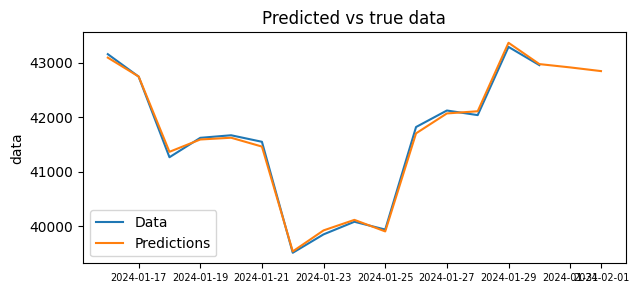

In [442]:
plt.figure(figsize=(7, 3))
plt.plot(df_true.close)
plt.plot(df_predictions.close.shift(-1))
plt.legend(('Data', 'Predictions'))
plt.title('Predicted vs true data')
plt.ylabel('data')
plt.xticks(size=7)
plt.show()